In [194]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, RandomSampler, DistributedSampler
#import torchvision
#import lightning


In [195]:
# data_dir = os.path.join(os.path.dirname(os.getcwd()), "Data/CIFAR10/cifar-10-batches-py/data_batch_1")
data_dir = os.path.join(
    os.path.dirname(os.getcwd()),
    "Data/CIFAR10/cifar-10-batches-py",
    "train_data.pkl",
)
data_dir_val = os.path.join(
    os.path.dirname(os.getcwd()), "Data/CIFAR10/cifar-10-batches-py/test_batch"
)
# batch_size = 2
num_in_channels = 3
dim_z = 64
kern_size = 4
lr = 2e-4
num_epochs = 3

num_disc_feat = 128
disc_stride = 1
disc_padding_size = 0

num_gen_feat = 128
gen_stride = 3
gen_padding_size = 1

mean = 0.0
std = 0.02  # from the DCGAN paper

if torch.cuda.is_available():
    device = "cuda"
elif torch.has_mps:
    device = "mps"
else:
    device = "cpu"


In [196]:
def unpickle(file):
    with open(file, "rb") as fo:
        dict = pickle.load(fo, encoding="bytes")
    return dict

In [102]:
def process_data(folder_dir):
    file_paths = os.listdir(folder_dir)
    combined_img_data = []
    combined_label_data = []
    for file in file_paths:
        if "data_batch" in file:
            combined_img_data.append(
                unpickle(os.path.join(folder_dir, file))[b"data"]
            )
            combined_label_data.append(
                unpickle(os.path.join(folder_dir, file))[b"labels"]
            )
    combined_img_data = np.concatenate(combined_img_data)
    combined_label_data = np.concatenate(combined_label_data)
    # with open(os.path.join(folder_dir, "train_img_data.pkl"), 'wb') as f:
    #     pickle.dump(combined_img_data, f)
    # with open(os.path.join(folder_dir, "train_label_data.pkl"), 'wb') as f:
    #     pickle.dump(combined_label_data, f)

    train_data = {}
    train_data[b"data"] = combined_img_data
    train_data[b"labels"] = combined_label_data
    with open(os.path.join(folder_dir, "train_data.pkl"), "wb") as f:
        pickle.dump(train_data, f)

In [ ]:
process_data(
    os.path.join(
        os.path.dirname(os.getcwd()), "Data/CIFAR10/cifar-10-batches-py"
    )
)

In [74]:
(unpickle(data_dir).keys())


dict_keys([b'data', b'labels'])

In [197]:
class TrainDataset(Dataset):
    def __init__(self, data_dir):
        super().__init__()
        self.train_data = unpickle(data_dir)

    def __getitem__(self, idx):
        img = torch.tensor(
            self.train_data[b"data"][idx].reshape(3, 32, 32).transpose(1, 2, 0)/255.0,
            dtype=torch.float32,
        )
        # img = torch.nn.functional.normalize(img)
        label = torch.tensor(
            self.train_data[b"labels"][idx], dtype=torch.float32
        )
        # return img, label
        return {"img": img, "label": label}

    def __len__(self):
        return len(self.train_data[b"labels"])

In [198]:
class ValDataset(Dataset):
    def __init__(self, data_dir):
        super().__init__()
        self.val_data = unpickle(data_dir)

    def __getitem__(self, idx):
        img = torch.tensor(
            self.val_data[b"data"][idx].reshape(3, 32, 32).transpose(1, 2, 0) / 255.0, dtype=torch.float32
        )
        # img = torch.nn.functional.normalize(img)
        label = torch.tensor(self.val_data[b"labels"][idx], dtype=torch.float32)
        # return img, label
        return {"img": img, "label": label}

    def __len__(self):
        return len(self.val_data[b"labels"])

In [199]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # self.ngpu = ngpu
        self.net = nn.Sequential(
            # nn.BatchNorm2d(num_in_channels),
            nn.Conv2d(
                num_in_channels,
                num_disc_feat,
                kern_size,
                disc_stride,
                disc_padding_size,
                bias=False,
            ),
            nn.LeakyReLU(),
            nn.Conv2d(
                num_disc_feat,
                num_disc_feat * 2,
                kern_size,
                4,
                disc_padding_size,
                bias=False,
            ),
            nn.BatchNorm2d(num_disc_feat * 2),
            nn.LeakyReLU(),
            nn.Conv2d(
                num_disc_feat * 2,
                num_disc_feat * 4,
                kern_size,
                disc_stride,
                disc_padding_size,
                bias=False,
            ),
            nn.BatchNorm2d(num_disc_feat * 4),
            nn.LeakyReLU(),
            nn.Conv2d(
                num_disc_feat * 4,
                1,
                kern_size,
                disc_stride,
                disc_padding_size,
                bias=False,
            ),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        for layer in self.net.modules():
            if isinstance(layer, nn.Conv2d):
                nn.init.normal_(layer.weight, mean, std)

    def forward(self, x):
        z = self.net(x)
        return z

In [200]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        # self.ngpu = ngpu
        self.net = nn.Sequential(
            nn.ConvTranspose2d(
                dim_z, num_gen_feat * 4, kern_size, 1, 0, bias=False
            ),
            # ConvTranspose2d are the fractionally strided convolutions used for upscaling mentioned in the paper
            nn.BatchNorm2d(num_gen_feat * 4),
            nn.ReLU(),
            nn.ConvTranspose2d(
                num_gen_feat * 4, num_gen_feat * 2, kern_size, 2, 1, bias=False
            ),
            nn.BatchNorm2d(num_gen_feat * 2),
            nn.ReLU(),
            nn.ConvTranspose2d(
                num_gen_feat * 2, num_gen_feat, kern_size, 2, 1, bias=False
            ),
            nn.BatchNorm2d(num_gen_feat),
            nn.ReLU(),
            nn.ConvTranspose2d(
                num_gen_feat, num_in_channels, kern_size, 2, 1, bias=False
            ),
            nn.Tanh(),
        )

        for layer in self.net.modules():
            if isinstance(layer, nn.ConvTranspose2d):
                nn.init.normal_(layer.weight, mean, std)

    def forward(self, x):
        z = self.net(x)
        return z

In [201]:
train_dataset = TrainDataset(data_dir)
train_sampler = DistributedSampler(train_dataset, num_replicas=1, rank=0, shuffle=True)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=100,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    sampler=train_sampler,
)

val_dataset = ValDataset(data_dir_val)
val_sampler = DistributedSampler(val_dataset, num_replicas=1, rank=0, shuffle=True)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=100,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    sampler=val_sampler,
)

In [202]:
def denormalize_images(images):
    # Reverse normalization
    denormalized_images = (images + 1) / 2.0
    denormalized_images = (denormalized_images * 255).astype(np.uint8)
    return denormalized_images


In [203]:
def train(num_epochs, data_dir, data_dir_val, device, train=True, **kwargs):

    loss_fn = torch.nn.BCEWithLogitsLoss()

    batch_size = kwargs.get("batch_size", 100)
    gen_lr = kwargs.get("gen_lr", 2e-4)
    disc_lr = kwargs.get("disc_lr", 2e-4)
    k = kwargs.get("k", 1)
    
    train_dataset = TrainDataset(data_dir)
    train_sampler = DistributedSampler(train_dataset, num_replicas=1, rank=0, shuffle=True)
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True,
        sampler=train_sampler,
    )
    if train == False:
        val_dataset = ValDataset(data_dir_val)
        val_sampler = DistributedSampler(val_dataset, num_replicas=1, rank=0, shuffle=True)
        val_loader = DataLoader(
            dataset=val_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=0,
            pin_memory=True,
            sampler=val_sampler,
        )
    
    optimG = torch.optim.AdamW(gen.parameters(), lr=gen_lr, betas=(0.5, 0.9), weight_decay=0.2)
    optimD = torch.optim.AdamW(disc.parameters(), lr=disc_lr, betas=(0.5, 0.9), weight_decay=0.1)
    # optimD = torch.optim.SGD(disc.parameters(), lr=2e-4)

    # noise = torch.randn(28, dim_z, 1, 1, device=device)

    # real_label = 1
    # fake_label = 0
    loss_d, loss_g, imgs = [], [], []
    
    if train:
        for i in range(num_epochs):
            print(f"Epoch no. :  {i+1}")
            nan_flag = False
            if nan_flag==False:
                
                for _ in range(k):
                    if nan_flag==False:
                        for j, mini_batch in enumerate(train_loader):

                            optimD.zero_grad()

                            # train disc first
                            x_real = mini_batch["img"].to(device)
                            x_real = x_real.reshape(batch_size, num_in_channels, 32, 32)
                            labels = torch.full(
                                (batch_size,), 1.0, dtype=torch.float32, device=device
                            )
                            # out_disc_r = disc(x_real).flatten().sigmoid()
                            out_disc_r = disc(x_real).flatten()

                            # print(out_disc_r)
                            loss_disc_r = loss_fn(out_disc_r, labels)
                            loss_disc_r.backward()

                            x_fake = gen(torch.rand(batch_size, dim_z, 1, 1, device=device))
                            labels = torch.full(
                                (batch_size,), 0.0, dtype=torch.float32, device=device
                            )
                            # out_disc_f = disc(x_fake).flatten().sigmoid()
                            out_disc_f = disc(x_fake).flatten()
                            loss_disc_f = loss_fn(out_disc_f, labels)
                            if torch.isnan(loss_disc_f) or torch.isnan(loss_disc_r):
                                nan_flag = True
                                break

                            loss_disc_f.backward()

                            loss_disc = (
                                loss_disc_f.mean().item() + loss_disc_r.mean().item()
                            ) / 2.0

                            loss_d.append(loss_disc)

                            if j % 1000 == 0:
                                print(f"Discriminator loss after {j} steps = {loss_d[j + _*train_dataset.__len__()//batch_size + i*train_dataset.__len__()//batch_size]}")

                            optimD.step()
                    
                for j, mini_batch in enumerate(train_loader):

                    # train gen
                    optimG.zero_grad()

                    x_gen = gen(torch.rand(batch_size, dim_z, 1, 1, device=device))
                    x_gen = torch.nn.functional.normalize(x_gen)
                    # out = disc(x_gen).flatten().sigmoid()
                    out = disc(x_gen).flatten()
                    labels = torch.full(
                        (batch_size,), 1.0, dtype=torch.float32, device=device
                    )
                    loss_gen = loss_fn(out, labels)
                    loss_gen.backward()

                    loss_g.append(loss_gen.item())

                    if loss_disc == np.NaN or loss_gen.item() == np.NaN:
                        nan_flag = True
                        break

                    optimG.step()

                    if j % 1000 == 0:
                        print(f"Generator loss after {j} steps = {loss_g[j + i*train_dataset.__len__()//batch_size]}")

                with torch.no_grad():
                    gen_img = gen(torch.rand(2, dim_z, 1, 1, device=device))
                    gen_img = denormalize_images(gen_img[0].cpu().detach().numpy().transpose(1, 2, 0))
                    imgs.append(gen_img)
                    plt.imshow(gen_img)
                    plt.show()
                    plt.imshow(mini_batch['img'][0].cpu().numpy())
                    plt.show()
                
    return loss_d, loss_g, imgs

In [204]:
disc = Discriminator().to(device)
gen = Generator().to(device)
loss_disc, loss_gen, images = [], [], []


In [ ]:
g_lr = 2e-4
for g_lr in np.arange(9e-5, 4e-4, 2e-5):
    for d_lr in np.arange(4e-5, 2e-4, 2e-5):
        for k in np.arange(2,5, 1):
            disc = Discriminator().to(device)
            gen = Generator().to(device)
            l_disc, l_gen, img = train(num_epochs=10, data_dir=data_dir,data_dir_val=data_dir_val, device=device, batch_size=50, disc_lr=d_lr, gen_lr=g_lr, k=k)
            loss_disc.append(l_disc)
            loss_gen.append(l_gen)
            images.append(img)

Epoch no. :  1
Discriminator loss after 0 steps = 0.7281532138586044
Discriminator loss after 0 steps = 0.7030836343765259
Generator loss after 0 steps = 0.5284931063652039


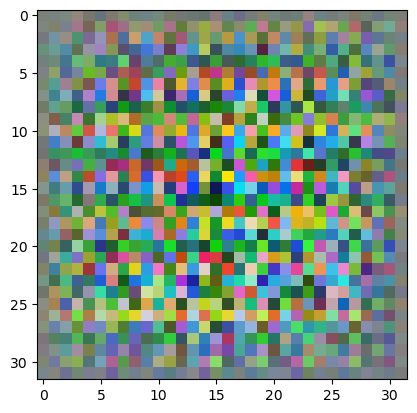

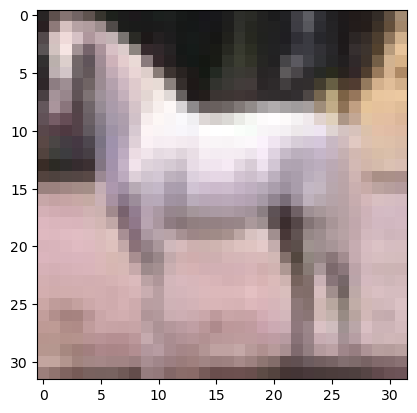

Epoch no. :  2
Discriminator loss after 0 steps = 0.7030836343765259
Discriminator loss after 0 steps = 0.7235980033874512
Generator loss after 0 steps = 0.5620638132095337


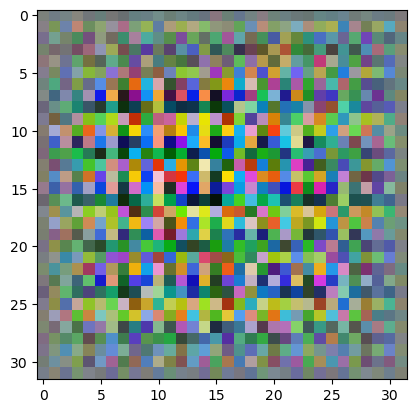

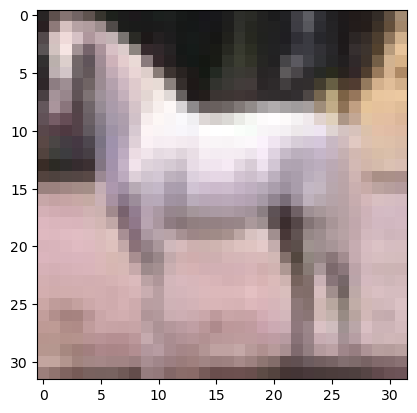

Epoch no. :  3
Discriminator loss after 0 steps = 0.7235980033874512
Discriminator loss after 0 steps = 0.6888741552829742
Generator loss after 0 steps = 0.5917022824287415


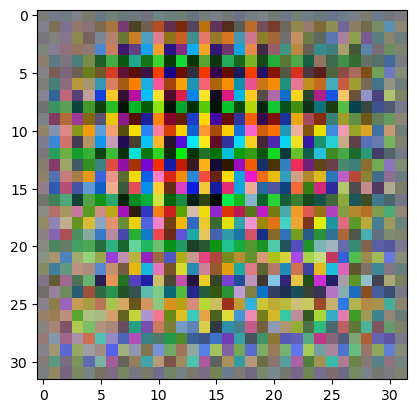

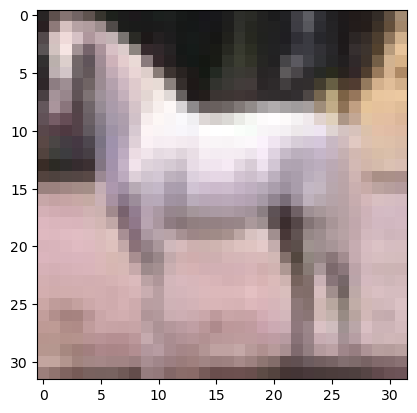

Epoch no. :  4
Discriminator loss after 0 steps = 0.6888741552829742
Discriminator loss after 0 steps = 0.7126283049583435
Generator loss after 0 steps = 0.5897470116615295


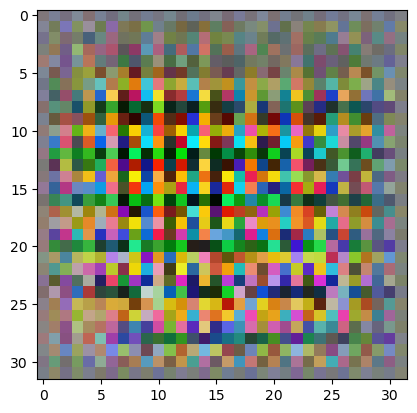

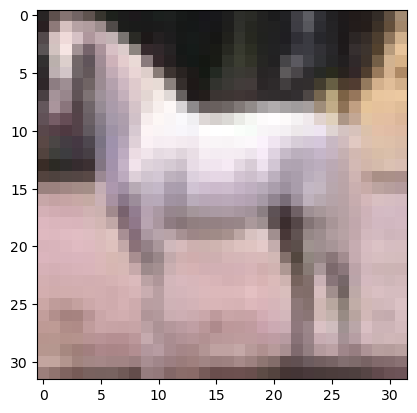

Epoch no. :  5
Discriminator loss after 0 steps = 0.7126283049583435
Discriminator loss after 0 steps = 0.672460526227951
Generator loss after 0 steps = 0.595876157283783


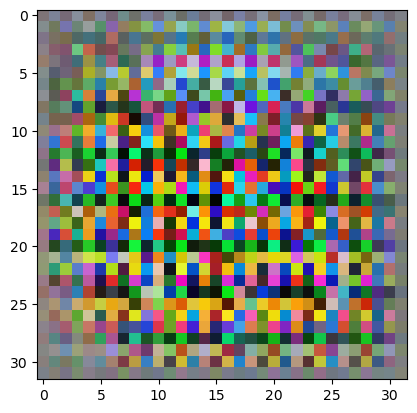

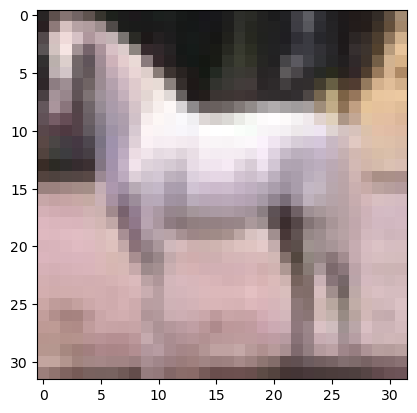

Epoch no. :  6
Discriminator loss after 0 steps = 0.672460526227951
Discriminator loss after 0 steps = 0.6819711029529572
Generator loss after 0 steps = 0.515117883682251


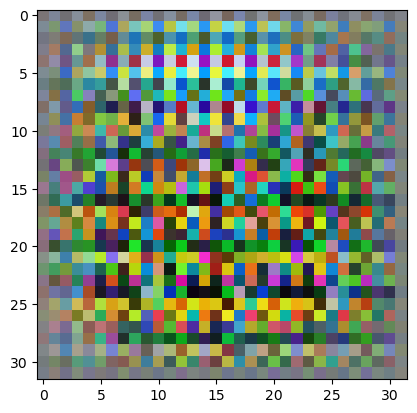

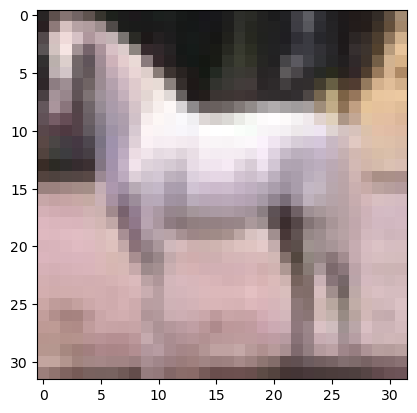

Epoch no. :  7
Discriminator loss after 0 steps = 0.6819711029529572
Discriminator loss after 0 steps = 0.6641466319561005
Generator loss after 0 steps = 0.6060353517532349


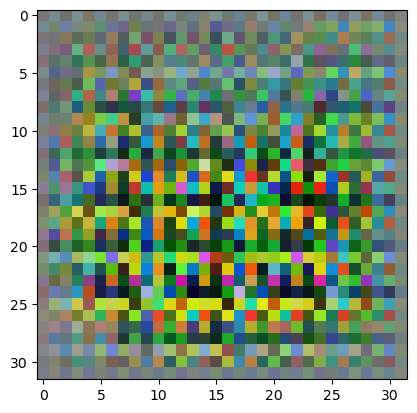

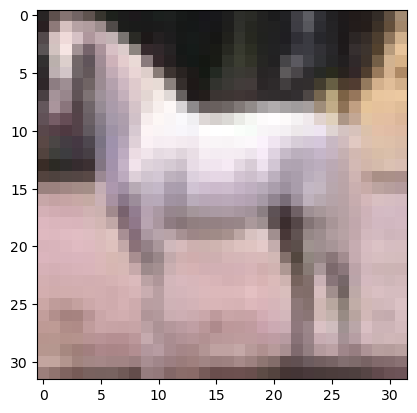

Epoch no. :  8
Discriminator loss after 0 steps = 0.6641466319561005
Discriminator loss after 0 steps = 0.7130400240421295
Generator loss after 0 steps = 0.5473785400390625


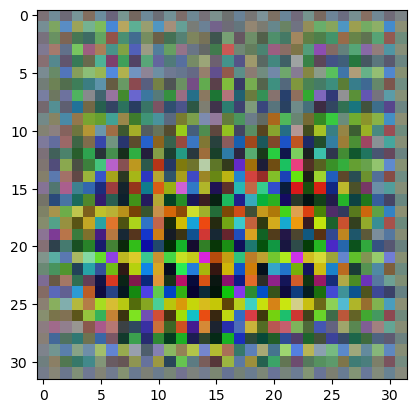

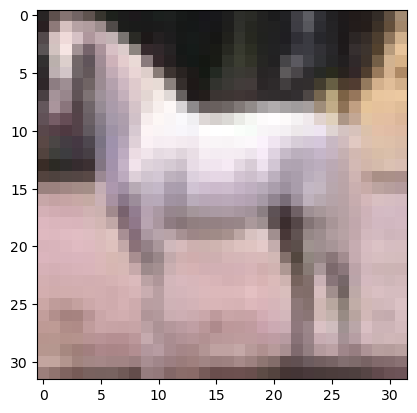

Epoch no. :  9
Discriminator loss after 0 steps = 0.7130400240421295
Discriminator loss after 0 steps = 0.6585274338722229
Generator loss after 0 steps = 0.5768507122993469


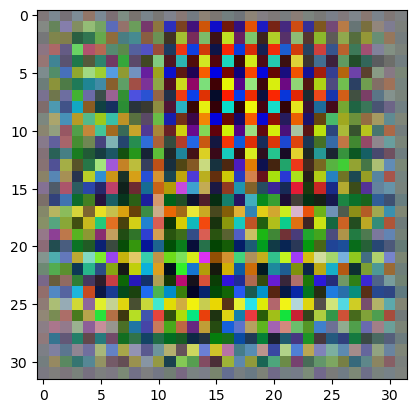

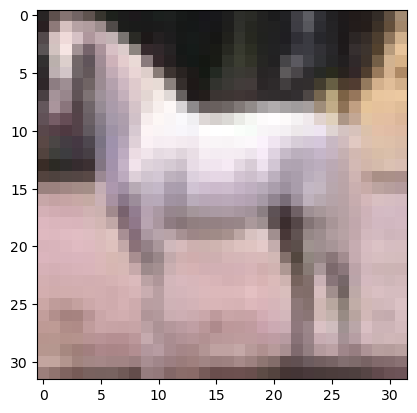

Epoch no. :  10
Discriminator loss after 0 steps = 0.6585274338722229
Discriminator loss after 0 steps = 0.6639237105846405
Generator loss after 0 steps = 0.6063941121101379


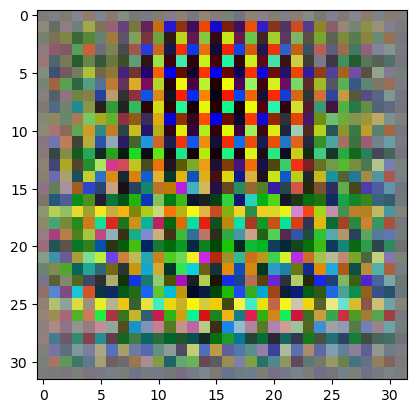

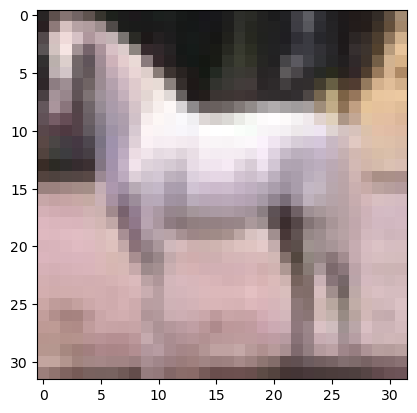

In [205]:
g_lr = 1e-4
d_lr = 2e-4
k = 2
num_epochs = 10
l_disc, l_gen, img = train(num_epochs, data_dir=data_dir,data_dir_val=data_dir_val, device=device, batch_size=50, disc_lr=d_lr, gen_lr=g_lr, k=k)
loss_disc.append(l_disc)
loss_gen.append(l_gen)
images.append(img)

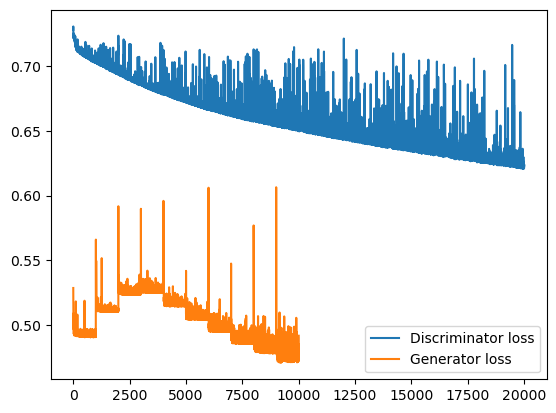

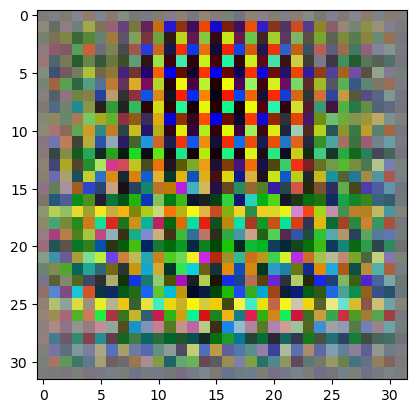

In [206]:
for i in range(len(loss_gen)):
    plt.plot(loss_disc[i])
    plt.plot(loss_gen[i])
    plt.legend(["Discriminator loss", "Generator loss"])
    plt.show()
    plt.imshow(images[i][-1])
    plt.show()
    # plt., loss_d[0]


In [207]:
with torch.no_grad():
    gen_img = gen(torch.randn(10, dim_z, 1, 1, device=device))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 32, 32])


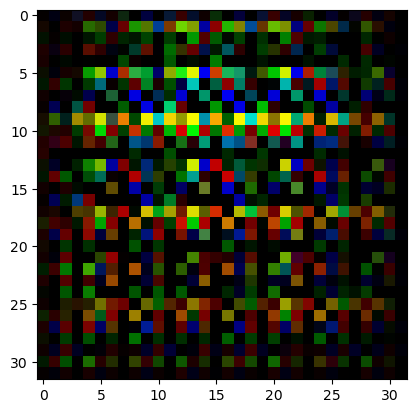

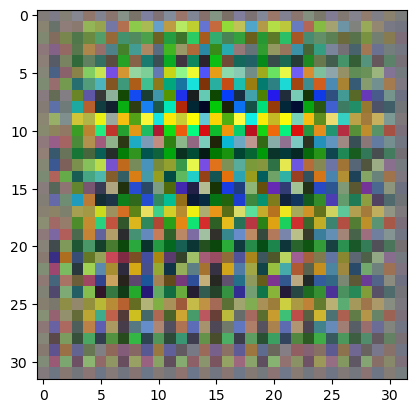

tensor([[[ 1.0960e-02, -8.2173e-03,  6.2436e-02,  ...,  5.5765e-03,
           1.0461e-01, -2.9044e-02],
         [ 8.3860e-02, -1.8681e-01,  1.5379e-01,  ...,  1.0676e-01,
           1.7484e-01, -1.1000e-01],
         [-4.4803e-04,  6.7097e-03, -3.2623e-02,  ..., -1.0737e-01,
           9.0527e-02, -2.4779e-02],
         ...,
         [ 6.2505e-02, -2.7915e-01,  2.2432e-01,  ..., -5.0707e-02,
           4.7593e-02, -1.0120e-01],
         [-3.3464e-03,  2.0611e-01, -2.4163e-02,  ...,  5.2017e-02,
           7.3874e-02, -1.1771e-02],
         [ 2.3774e-02, -1.3290e-01,  6.0224e-02,  ..., -1.3152e-01,
           5.9894e-02, -5.7914e-02]],

        [[-2.4448e-02, -4.7610e-02,  1.7109e-02,  ..., -2.7891e-02,
           2.3493e-02, -1.6349e-02],
         [ 8.3498e-03, -2.3952e-01, -3.3305e-02,  ..., -3.5588e-02,
          -7.0907e-02, -9.2073e-02],
         [ 7.6272e-02, -2.5749e-01,  1.6783e-01,  ..., -1.1042e-01,
           6.7616e-02, -1.4600e-01],
         ...,
         [-5.5574e-02, -3

In [208]:
print(gen_img[0].shape)
plt.imshow(gen_img[1].cpu().detach().numpy().transpose(1, 2, 0))
plt.show()
plt.imshow(denormalize_images(gen_img[1].cpu().detach().numpy().transpose(1, 2, 0)))
plt.show()
print(gen_img[0])
# print(disc(gen_img).flatten())

In [ ]:
loss_fn = torch.nn.BCELoss()

train_dataset = TrainDataset(data_dir)
train_sampler = DistributedSampler(train_dataset, num_replicas=1, rank=0)
batch_size = 50
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    sampler=train_sampler,
)
if train == False:
    val_dataset = ValDataset(data_dir_val)
    val_sampler = DistributedSampler(val_dataset, num_replicas=1, rank=0)
    val_loader = DataLoader(
        dataset=val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True,
        sampler=val_sampler,
    )

optimG = torch.optim.Adam(gen.parameters(), lr=2e-4, betas=(0.5, 0.0))
optimD = torch.optim.Adam(disc.parameters(), lr=2e-4, betas=(0.5, 0.0))

# for j, mini_batch in enumerate(train_loader):
mini_batch = next(iter(train_loader))
optimG.zero_grad()

for _ in range(3):
    optimD.zero_grad()

    # train disc first
    x_real = mini_batch["img"].to(device)
    x_real = x_real.view(batch_size, num_in_channels, 32, 32)
    labels = torch.full(
        (batch_size,), 1.0, dtype=torch.float32, device=device
    )
    # out_disc_r = disc(x_real).flatten().sigmoid()
    out_disc_r = disc(x_real).flatten()

    # print(out_disc_r)
    loss_disc_r = loss_fn(out_disc_r, labels)
    loss_disc_r.backward()

    x_fake = gen(torch.randn(batch_size, dim_z, 1, 1))
    labels = torch.full(
        (batch_size,), 0.0, dtype=torch.float32, device=device
    )
    # out_disc_f = disc(x_fake).flatten().sigmoid()
    out_disc_f = disc(x_fake).flatten()
    loss_disc_f = loss_fn(out_disc_f, labels)
    loss_disc_f.backward()

    loss_disc = (
        loss_disc_f.mean().item() + loss_disc_r.mean().item()
    ) / 2.0
    if _ != 2:
        optimD.step()

# train gen
x_gen = gen(torch.randn(batch_size, dim_z, 1, 1))
# out = disc(x_gen).flatten().sigmoid()
out = disc(x_gen).flatten()
labels = torch.full(
    (batch_size,), 1.0, dtype=torch.float32, device=device
)
loss_gen = loss_fn(out, labels)
loss_gen.backward()


# optimG.step()

In [ ]:
def train(gpu, args):
    rank = args.nr * args.gpus + gpu
    torch.distributed.init_process_group(
        backend="nccl",
        init_method="env://",
        world_size=args.world_size,
        rank=rank,
    )

    torch.manual_seed(0)
    torch.cuda.set_device(gpu)
    model = test_net().cuda(gpu)

    batch_size = 100

    loss_fn = torch.nn.BCELoss()
    optim = torch.optim.Adam(model.parameters(), lr=1e4)
    model = nn.parallel.DistributedDataParallel(model, device_ids=[gpu])
    # model, optimizer = amp.initialize(model, optimizer, opt_level="O2")
    # model = DDP(model)

    total_steps = len(train_loader)
    for epoch in range(args.epochs):
        for i, (images, labels) in enumerate(train_loader):
            images = images.cuda(non_blocking=True)
            labels = labels.cuda(non_blocking=True)

            if (i + 1) % 100 == 0 and gpu == 0:
                print(
                    "Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}".format(
                        epoch + 1, args.epochs, i + 1, total_steps, loss.item()
                    )
                )